In [1]:
import os
import warnings
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:
    train_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_train=True,
        download=config["download"],
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_val=True,
        download=config["download"],
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_test=True,
        download=config["download"],
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )
    return train_dataloader, val_dataloader, test_dataloader

In [3]:
class Memory(nn.Module):
    def __init__(self, size: int) -> None:
        super(Memory, self).__init__()
        self.size = size

        initial_state = torch.ones(self.size) * 1e-6
        self.register_buffer("initial_state", initial_state.data)

        self.initial_read = nn.Parameter(torch.randn(1, self.size[1]) * 0.01)

    def reset(self, batch_size: int) -> None:
        self.matrix = self.initial_state.clone().repeat(batch_size, 1, 1)

    def get_initial_read(self, batch_size: int) -> torch.Tensor:
        return self.initial_read.clone().repeat(batch_size, 1)

    def write(self, w: torch.Tensor, e: torch.Tensor, a: torch.Tensor) -> None:
        self.matrix = self.matrix * (1 - torch.matmul(w.unsqueeze(-1), e.unsqueeze(1)))
        self.matrix = self.matrix + torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))

In [4]:
class Head(nn.Module):
    def __init__(self, memory: Memory, hidden_size: int) -> None:
        super(Head, self).__init__()
        self.memory = memory
        self.k_layer = nn.Linear(hidden_size, self.memory.size[1])
        self.beta_layer = nn.Linear(hidden_size, 1)
        self.g_layer = nn.Linear(hidden_size, 1)
        self.s_layer = nn.Linear(hidden_size, 3)
        self.gamma_layer = nn.Linear(hidden_size, 1)

        for layer in [self.k_layer, self.beta_layer, self.g_layer, self.s_layer, self.gamma_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

        self._initial_state = nn.Parameter(torch.randn(1, self.memory.size[0]) * 1e-5)

    def get_initial_state(self, batch_size: int) -> torch.Tensor:
        return F.softmax(self._initial_state, dim=1).repeat(batch_size, 1)

    def get_head_weight(
        self, x: torch.Tensor, previous_state: torch.Tensor, memory_matrix: torch.Tensor
    ) -> torch.Tensor:
        k = self.k_layer(x)
        beta = F.softplus(self.beta_layer(x))
        g = torch.sigmoid(self.g_layer(x))
        s = F.softmax(self.s_layer(x), dim=1)
        gamma = 1 + F.softplus(self.gamma_layer(x))

        w_c = F.softmax(
            beta * F.cosine_similarity(memory_matrix + 1e-16, k.unsqueeze(1) + 1e-16, dim=-1), dim=1
        )
        w_g = g * w_c + (1 - g) * previous_state
        w_t = self._shift(w_g, s)

        w = w_t**gamma
        w = torch.div(w, torch.sum(w, dim=1).unsqueeze(1) + 1e-16)
        return w

    def _convolve(self, w: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        assert s.size(0) == 3
        t = torch.cat([w[-1:], w, w[:1]], dim=0)
        c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
        return c

    def _shift(self, w_g: torch.Tensor, s: torch.Tensor) -> torch.Tensor:
        result = w_g.clone()
        for b in range(len(w_g)):
            result[b] = self._convolve(w_g[b], s[b])
        return result

In [5]:
class ReadHead(Head):
    def forward(
        self, x: torch.Tensor, previous_state: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        return torch.matmul(w.unsqueeze(1), self.memory.matrix).squeeze(1), w

In [6]:
class WriteHead(Head):
    def __init__(self, memory: Memory, hidden_size: int) -> None:
        super(WriteHead, self).__init__(memory=memory, hidden_size=hidden_size)
        self.e_layer = nn.Linear(hidden_size, memory.size[1])
        self.a_layer = nn.Linear(hidden_size, memory.size[1])

        for layer in [self.e_layer, self.a_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

    def forward(self, x: torch.Tensor, previous_state: torch.Tensor) -> torch.Tensor:
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        e = torch.sigmoid(self.e_layer(x))
        a = self.a_layer(x)

        self.memory.write(w, e, a)
        return w

In [7]:
class LSTMController(nn.Module):
    def __init__(self, input_size: int, hidden_size: int) -> None:
        super(LSTMController, self).__init__()
        self.layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.lstm_h_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        self.lstm_c_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)

        for p in self.layer.parameters():
            if p.dim() == 1:
                nn.init.constant_(p, 0)
            else:
                stdev = 5 / (np.sqrt(input_size + hidden_size))
                nn.init.uniform_(p, -stdev, stdev)

    def get_initial_state(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
        lstm_h = self.lstm_h_state.clone().repeat(1, batch_size, 1)
        lstm_c = self.lstm_c_state.clone().repeat(1, batch_size, 1)
        return lstm_h, lstm_c

    def forward(
        self, x: torch.Tensor, state: Tuple[torch.Tensor]
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor]]:
        output, state = self.layer(x.unsqueeze(0), state)
        return output.squeeze(0), state

In [8]:
class NTM(nn.Module):
    def __init__(
        self,
        num_ways: int,
        img_size: int = 28,
        memory_size: Tuple[int, int] = (128, 40),
        hidden_size: int = 200,
    ) -> None:
        super(NTM, self).__init__()
        input_size = img_size * img_size + num_ways
        controller_input_size = input_size + memory_size[1]

        self.memory = Memory(size=memory_size)
        self.read_head = ReadHead(memory=self.memory, hidden_size=hidden_size)
        self.write_head = WriteHead(memory=self.memory, hidden_size=hidden_size)
        self.controller = LSTMController(input_size=controller_input_size, hidden_size=hidden_size)

        self.fc = nn.Linear(hidden_size + memory_size[1], 5)
        nn.init.xavier_uniform_(self.fc.weight, gain=1)
        nn.init.normal_(self.fc.bias, std=0.01)

    def get_initial_state(
        self, batch_size: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Tuple[torch.Tensor]]:
        self.memory.reset(batch_size)
        read = self.memory.get_initial_read(batch_size)
        read_head_state = self.read_head.get_initial_state(batch_size)
        write_head_state = self.write_head.get_initial_state(batch_size)
        controller_state = self.controller.get_initial_state(batch_size)
        return (read, read_head_state, write_head_state, controller_state)

    def forward(
        self,
        x: torch.Tensor,
        previous_state: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Tuple[torch.Tensor]],
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Tuple[torch.Tensor]]]:
        (
            previous_read,
            previous_read_head_state,
            previous_write_head_state,
            previous_controller_state,
        ) = previous_state

        controller_input = torch.cat([x, previous_read], dim=1)
        controller_output, controller_state = self.controller(
            controller_input, previous_controller_state
        )
        read_head_output, read_head_state = self.read_head(controller_output, previous_read_head_state)
        write_head_state = self.write_head(controller_output, previous_write_head_state)

        fc_input = torch.cat((controller_output, read_head_output), dim=1)
        state = (read_head_output, read_head_state, write_head_state, controller_state)
        return F.softmax(self.fc(fc_input), dim=1), state

In [9]:
def generate_sequence(xs: torch.Tensor, ys: torch.Tensor, num_ways: int, device: str) -> torch.Tensor:
    xs_flat = xs.flatten(2, 4)

    ys_onehot = F.one_hot(ys, num_classes=num_ways)
    ys_cat = torch.cat(
        (torch.zeros(ys_onehot.shape[0], 1, ys_onehot.shape[2]).to(device=device), ys_onehot), dim=1
    )[:, :-1, :]

    seq = torch.cat((xs_flat, ys_cat), dim=2)
    return torch.swapaxes(seq, 0, 1)


def generate_sequence_v2(
    task_batch: Dict[str, List[torch.Tensor]], device: str, num_ways: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    random_indices = torch.randperm(5)
    query_xs_ = query_xs[:, random_indices, :, :, :]
    query_ys_ = query_ys[:, random_indices]

    support_seq = generate_sequence(xs=support_xs, ys=support_ys, num_ways=num_ways, device=device)
    query_seq = generate_sequence(xs=query_xs_, ys=query_ys_, num_ways=num_ways, device=device)

    x_seq = torch.cat((support_seq, query_seq), dim=0)
    y_seq = torch.cat((support_ys, query_ys_), dim=1)
    return x_seq, y_seq

In [10]:
def train_mann(
    num_ways: int,
    num_shots: int,
    task_batch_size: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: NTM,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.RMSprop,
) -> Tuple[float, float]:
    model.train()

    x_seq_, y_seq_ = generate_sequence_v2(task_batch=task_batch, device=device, num_ways=num_ways)
    x_seq = x_seq_.to(device=device)
    y_seq = y_seq_.to(device=device)

    state = model.get_initial_state(batch_size=task_batch_size)
    prob = torch.zeros((len(x_seq), task_batch_size, num_ways)).to(device=device)
    for j, vector in enumerate(x_seq):
        prob[j], state = model(vector, state)
    prob_ = prob.permute(1, 2, 0)
    loss = criterion(prob_, y_seq)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        num_query = num_ways * num_shots
        correct = torch.sum(prob_[..., -num_query:].argmax(dim=1) == y_seq[..., -num_query:])
        accuracy = correct.item() / np.prod(y_seq[..., -num_query:].size())
    return accuracy, loss.item()

In [11]:
def test_mann(
    num_ways: int,
    num_shots: int,
    task_batch_size: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: NTM,
    criterion: nn.CrossEntropyLoss,
) -> Tuple[float, float]:
    model.eval()

    x_seq_, y_seq_ = generate_sequence_v2(task_batch=task_batch, device=device, num_ways=num_ways)
    x_seq = x_seq_.to(device=device)
    y_seq = y_seq_.to(device=device)

    state = model.get_initial_state(task_batch_size)
    prob = torch.zeros((len(x_seq), task_batch_size, num_ways)).to(device=device)
    for i, vector in enumerate(x_seq):
        prob[i], state = model(vector, state)
    prob_ = prob.permute(1, 2, 0)
    loss = criterion(prob_, y_seq)

    with torch.no_grad():
        num_query = num_ways * num_shots
        correct = torch.sum(prob_[..., -num_query:].argmax(dim=1) == y_seq[..., -num_query:])
        accuracy = correct.item() / np.prod(y_seq[..., -num_query:].size())
    return accuracy, loss.item()

In [12]:
def save_model(output_folder: str, model: NTM, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: NTM, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [13]:
def print_graph(
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_losses: List[float],
    val_losses: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [15]:
config = {
    "folder_name": "dataset",
    "download": True,
    "num_shots": 1,
    "num_ways": 5,
    "output_folder": "saved_model",
    "task_batch_size": 32,  # 필수
    "num_task_batch_train": 100000,  # 필수
    "num_task_batch_test": 30000,  # 필수
    "device": "cuda",  # 필수
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = NTM(num_ways=config["num_ways"]).to(device=config["device"])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), momentum=0.9, alpha=0.95, lr=1e-4)

  0%|          | 0/9464212 [00:00<?, ?it/s]

  0%|          | 0/6462886 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [38:00<00:00,  2.63it/s, train_accuracy=0.4437, train_loss=1.3823, val_accuracy=0.4625, val_loss=1.3914]


Model is saved in saved_model/mann.th


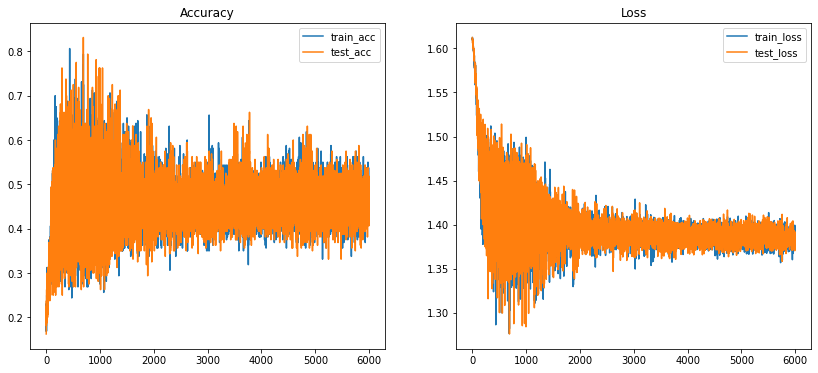

In [16]:
# 메타-트레이닝
with tqdm(zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]) as pbar:
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_train"]:
            break

        train_accuracy, train_loss = train_mann(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            task_batch_size=config["task_batch_size"],
            device=config["device"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_accuracy, val_loss = test_mann(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            task_batch_size=config["task_batch_size"],
            device=config["device"],
            task_batch=val_batch,
            model=model,
            criterion=criterion,
        )

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # 모델 저장하기
    save_model(output_folder=config["output_folder"], model=model, title="mann.th")

    print_graph(
        train_accuracies=train_accuracies,
        val_accuracies=val_accuracies,
        train_losses=train_losses,
        val_losses=val_losses,
    )

In [17]:
# 모델 불러오기
load_model(output_folder=config["output_folder"], model=model, title="mann.th")

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_test"]:
            break

        test_accuracy, test_loss = test_mann(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            task_batch_size=config["task_batch_size"],
            device=config["device"],
            task_batch=test_batch,
            model=model,
            criterion=criterion,
        )

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Model is loaded


100%|██████████| 2000/2000 [04:15<00:00,  7.81it/s, test_accuracy=0.4649, test_loss=1.3844]
